References : https://www.kaggle.com/code/akritiupadhyayks/cyber-attack-detection-with-random-forest

In [ ]:
!pip install dtreeviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')
# from ydata_profiling import ProfileReport
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from google.colab import files

sns.set_context('notebook')
sns.set_style('white')

## Data Preparation

In [ ]:
training = pd.read_csv("/content/UNSW_NB15_training-set.csv")
testing = pd.read_csv("/content/UNSW_NB15_testing-set.csv")
print("training ",training.shape)
print("testing ",testing.shape)

training  (82332, 45)
testing  (175341, 45)


In [ ]:
all(training.columns == testing.columns)

True

In [ ]:
df = pd.concat([training,testing]).drop('id',axis=1)
df = df.reset_index(drop=True)

df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0


## Exploratory Data Analysis

In [ ]:
# prof = ProfileReport(df)
# prof.to_file(output_file='report.html')
# files.download('report.html')

In [ ]:
df.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

## Handling categorical variables

In [ ]:
for col in ['proto', 'service', 'state']:
    df[col] = df[col].astype('category').cat.codes

df['attack_cat'] = df['attack_cat'].astype('category')

In [ ]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,119,0,5,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,119,0,5,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,119,0,5,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,119,0,5,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,119,0,5,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0


## Visualizing attack categories

attack_cat
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Normal                0
Name: count, dtype: int64


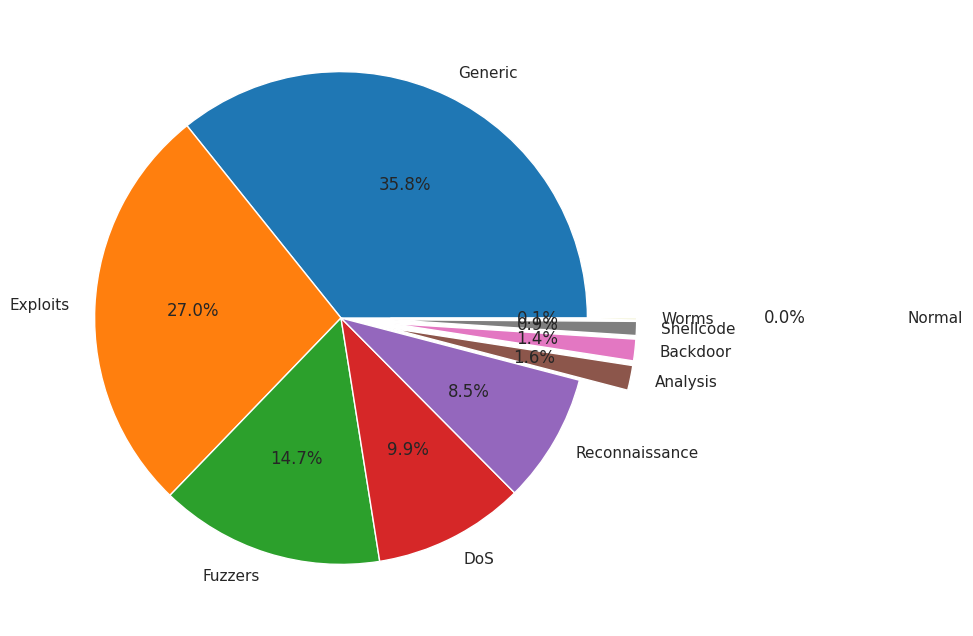

In [ ]:
validAttacks = df[df['label']==1]['attack_cat'].value_counts()
print(validAttacks)

plt.figure(figsize = (15,8))
plt.pie(validAttacks,labels = validAttacks.index, autopct = '%1.1f%%',explode = [0,0,0,0,0,0.2,0.2,0.2,0.2,1.2])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

df = df.dropna(subset=['label'])

X = df.drop(columns = ['attack_cat', 'label'])
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

feature_names = list(X.columns)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (180371, 42)
y_train shape:  (180371,)
X_test shape:  (77302, 42)
y_test shape:  (77302,)


## Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best recall score: 1.0


In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

clf=grid_search.best_estimator_
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

Recall:  1.0


## Visualizing the rules

In [ ]:
import warnings
warnings.filterwarnings("ignore")

:::::::> The RULES FOR HIGH RECALL RATE <::::::: 
 |--- sttl <= 61.00
|   |--- sinpkt <= 0.00
|   |   |--- class: 1
|   |--- sinpkt >  0.00
|   |   |--- class: 0
|--- sttl >  61.00
|   |--- synack <= 0.04
|   |   |--- class: 1
|   |--- synack >  0.04
|   |   |--- class: 1



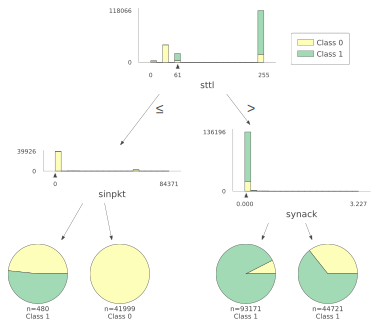

In [ ]:
from sklearn.tree import export_text
import dtreeviz

print(":::::::> The RULES FOR HIGH RECALL RATE <::::::: \n" ,export_text(clf,feature_names=feature_names))

plt.rcParams['font.family'] = 'DejaVu Sans'

viz_model = dtreeviz.model(clf,
                           X_train=X_train, y_train=y_train,
                           feature_names=feature_names)

viz_model.view()

## Filtering data for potential attacks

In [ ]:
X_test = X_test.reset_index(drop=True)

rules= "(sttl <= 61.00 & sinpkt<= 0.00) | (sttl >  61.00 )"

ind = X_test.query(rules).index

X_test_2 = X_test.loc[ind,:]
y_test_2 = y_test[ind]

print(X_test.shape)
print(X_test_2.shape)
print("filtered data" , (1- np.round(X_test_2.shape[0] / X_test.shape[0],2))*100, "%")

(77302, 42)
(59425, 42)
filtered data 23.0 %


In [ ]:
from sklearn.metrics import accuracy_score, precision_score

In [ ]:
def model_evaluation(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test_2)

    accuracy = accuracy_score(y_test_2, y_pred)
    recall = recall_score(y_test_2, y_pred)
    precision = precision_score(y_test_2, y_pred)
    print("Recall: ", recall)
    print("Precision: ", precision)
    print("Accuracy: ", accuracy)

    cross = pd.crosstab(pd.Series(y_test_2, name='Actual'), pd.Series(y_pred, name='Predicted'))
    plt.figure(figsize=(5, 5))
    sns.heatmap(cross, annot=True,fmt='d', cmap="YlGnBu")
    plt.show()

    return {'Recall' : recall}

In [ ]:
results = {}

## Random Forest Model

Recall:  0.9571815389589395
Precision:  0.9647257693326001
Accuracy:  0.9351956247370635


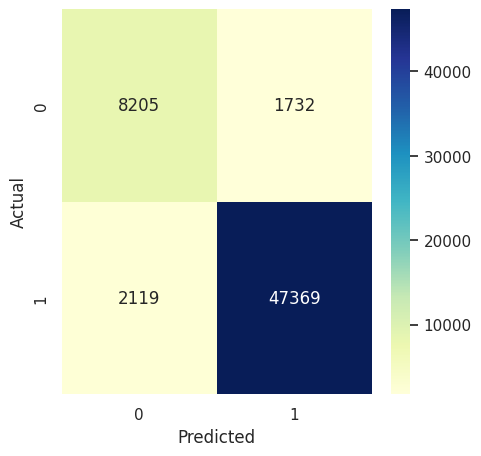

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=11)

results['Random Forest Model'] = model_evaluation(rf)

## Visualizing the rules present in the tree

In [ ]:
from sklearn.tree import export_text
feature_names = list(X.columns)

print(export_text(rf.estimators_[99],feature_names=feature_names))

|--- dpkts <= 0.50
|   |--- ct_srv_src <= 2.50
|   |   |--- sbytes <= 53.00
|   |   |   |--- sinpkt <= 30000.02
|   |   |   |   |--- sbytes <= 26.00
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- sbytes >  26.00
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- sinpkt >  30000.02
|   |   |   |   |--- class: 0.0
|   |   |--- sbytes >  53.00
|   |   |   |--- rate <= 0.11
|   |   |   |   |--- sbytes <= 62.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- sbytes >  62.50
|   |   |   |   |   |--- sttl <= 143.00
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- sttl >  143.00
|   |   |   |   |   |   |--- ct_src_dport_ltm <= 1.50
|   |   |   |   |   |   |   |--- sinpkt <= 5037.05
|   |   |   |   |   |   |   |   |--- ct_srv_dst <= 1.50
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- ct_srv_dst >  1.50
|   |   |   |   |   |   |   |   |   |--- sbytes <= 803.00
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
| 

## XGBoost

Recall:  0.9517458777885548
Precision:  0.9657774405872583
Accuracy:  0.931729070256626


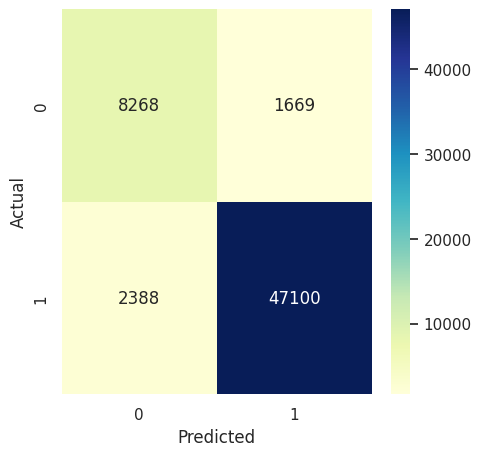

In [ ]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()

results['XGBoost Classifier'] = model_evaluation(xgbc)

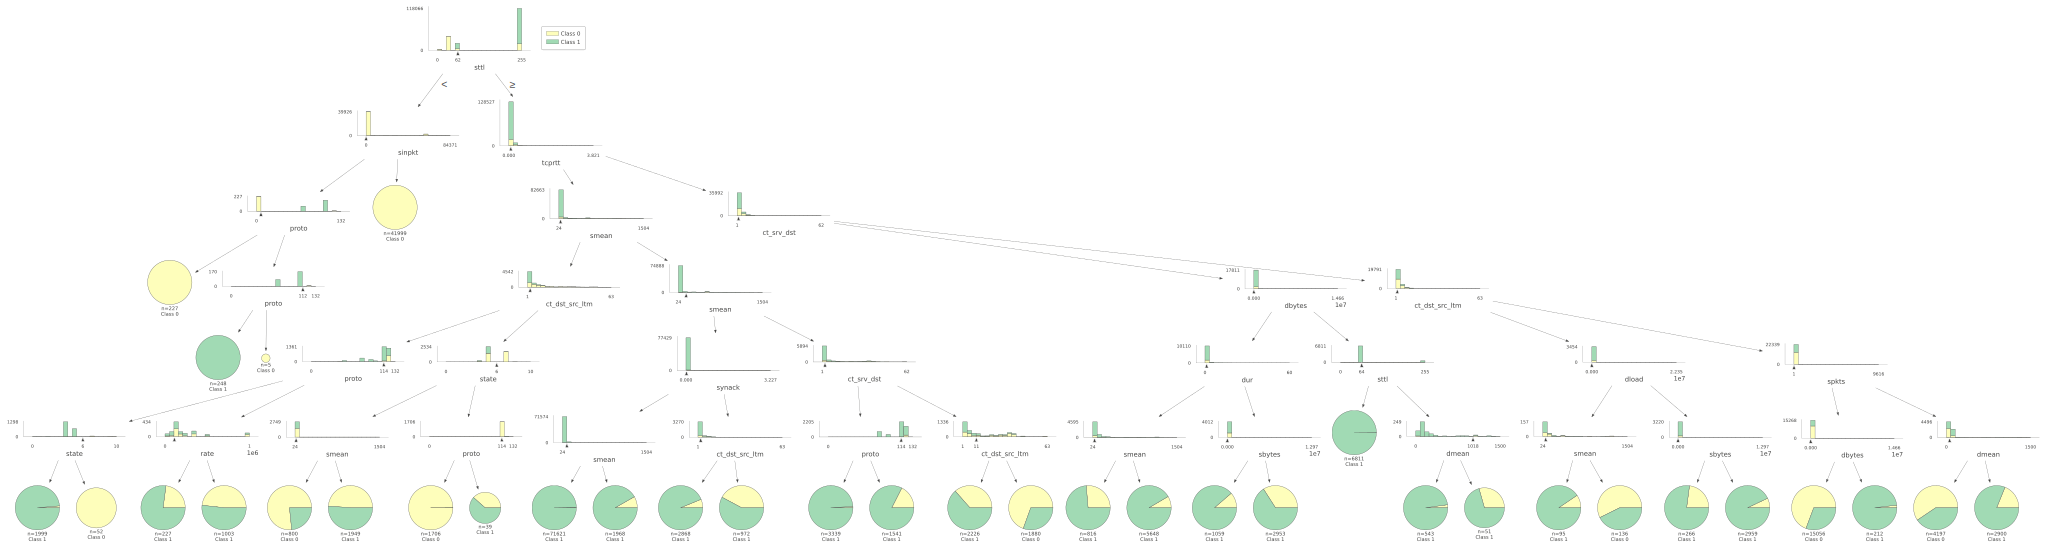

In [ ]:
viz_model = dtreeviz.model(xgbc,tree_index=1,
                           X_train=X_train, y_train=y_train,
                           feature_names=feature_names)
viz_model.view()

## Light GBM classifier

[LightGBM] [Info] Number of positive: 115185, number of negative: 65186
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6184
[LightGBM] [Info] Number of data points in the train set: 180371, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.638600 -> initscore=0.569295
[LightGBM] [Info] Start training from score 0.569295
Recall:  0.9465122858066602
Precision:  0.964898547739211
Accuracy:  0.9267816575515355


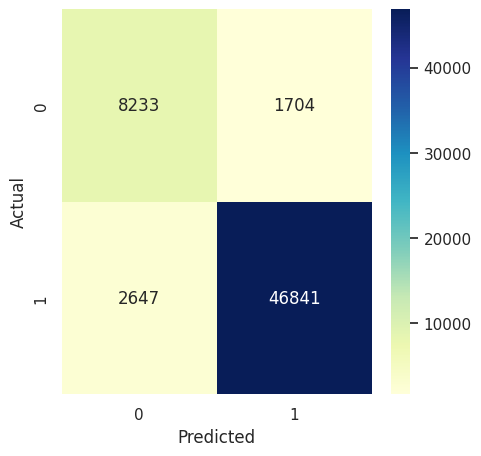

In [ ]:
from lightgbm import LGBMClassifier

lgbc = LGBMClassifier()

results['Light GBM Classifier'] = model_evaluation(lgbc)

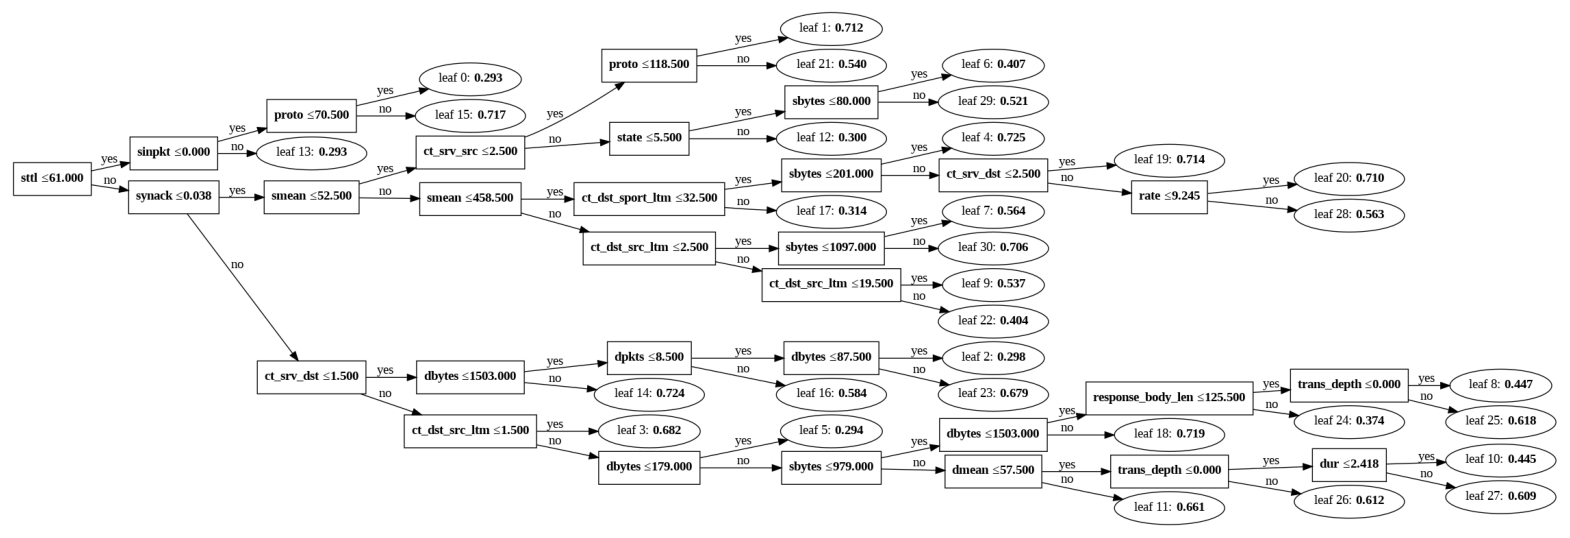

In [ ]:
import lightgbm

lightgbm.plot_tree(lgbc,figsize = (20,12))
plt.show()

In [ ]:
comparision = pd.DataFrame(results)
comparision

,Random Forest Model,XGBoost Classifier,Light GBM Classifier
Recall,0.957182,0.951746,0.946512


## Hypothesis Testing
Null Hypothesis : There is no difference in the recall of the three models

In [ ]:
from scipy.stats import wilcoxon

z_statistic, p_value = wilcoxon([comparision.iloc[0][0], comparision.iloc[0][1], comparision.iloc[0][2]])

# Print the results
print('Z-statistic:', z_statistic)
print('p-value:', p_value)

# Interpret the results
if p_value < 0.05:
    print('The difference in the recall of the three models is statistically significant.')
else:
    print('The difference in the recall of the three models is not statistically significant.')

Z-statistic: 0.0
p-value: 0.25
The difference in the recall of the three models is not statistically significant.


## Correlations

In [ ]:
feature_imp = pd.DataFrame({'Name':X.columns, 'Importance':rf.feature_importances_})

feature_imp = feature_imp.sort_values('Importance',ascending=False).reset_index(drop=True)

feature_imp[:10].style.background_gradient()

,Name,Importance
0,sttl,0.127183
1,ct_state_ttl,0.098745
2,rate,0.056321
3,dload,0.049838
4,sload,0.045773
5,sbytes,0.043195
6,ct_srv_dst,0.040537
7,smean,0.039754
8,ct_dst_src_ltm,0.038934
9,tcprtt,0.033016


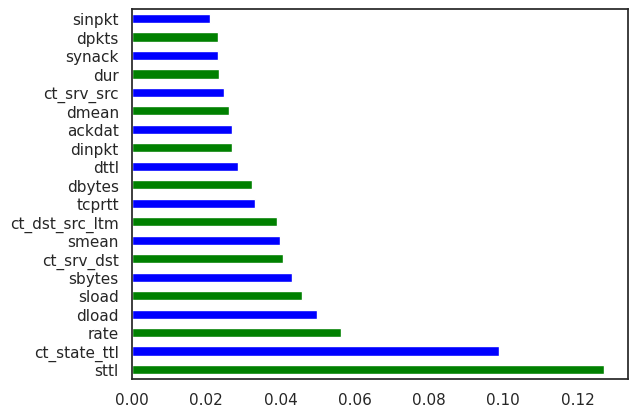

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh',color=['g','b']*5)
plt.show()

In [ ]:
import joblib

joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [ ]:
from google.colab import files

# Download the model to your local machine
files.download('random_forest_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>